In [163]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, load_digits
import os
import urllib.request
import zipfile
import io
import ssl
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import pandas as pd
import time
from math import ceil, floor
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint as pp 

# Question 1: SVM and MLP For Classifying Half Moons and Circles

In [2]:
# Specify the directory name
directories = ["results", "visualizations"]

In [3]:
# Create the directory
for directory_name in directories:
    try:
        os.mkdir(directory_name)
        print(f"Directory '{directory_name}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists.")
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

Directory 'results' already exists.
Directory 'visualizations' already exists.


## Explain and report your choices of design and hyper-parameters.

**Design Choices**
Based on the textbook readings, I chose to implement Sequential Minimal Optimization (SMO), rather than the gradient approach from class for precise Lagrange multiplier updates and explicit KKT condition checks in the dual problem. I also chose one kernel class methodrather than multiple for improved readibility and to better follow scikit-learn's convention for default behavior.

**Hyperparamter Choices**: C was initialized to the value 10. When you look below, an initial experiment was ran on the Circles Dataset of Sample 1000. Here I compared the accuracy, f1, recall, precision and run time for each of the different model configurations. Despite higher C values being associated with minimizing error on training data, leading to overfitting when introduced to unseen data, on average C=10 had the smallest variance in performance metrics between train and test sets compared to C=0.1 and C=1. The increased complexity of the decision function did increase runtime for training which is a tradeoff. But, regardless, I chose C=10 as it showed better generalizability.

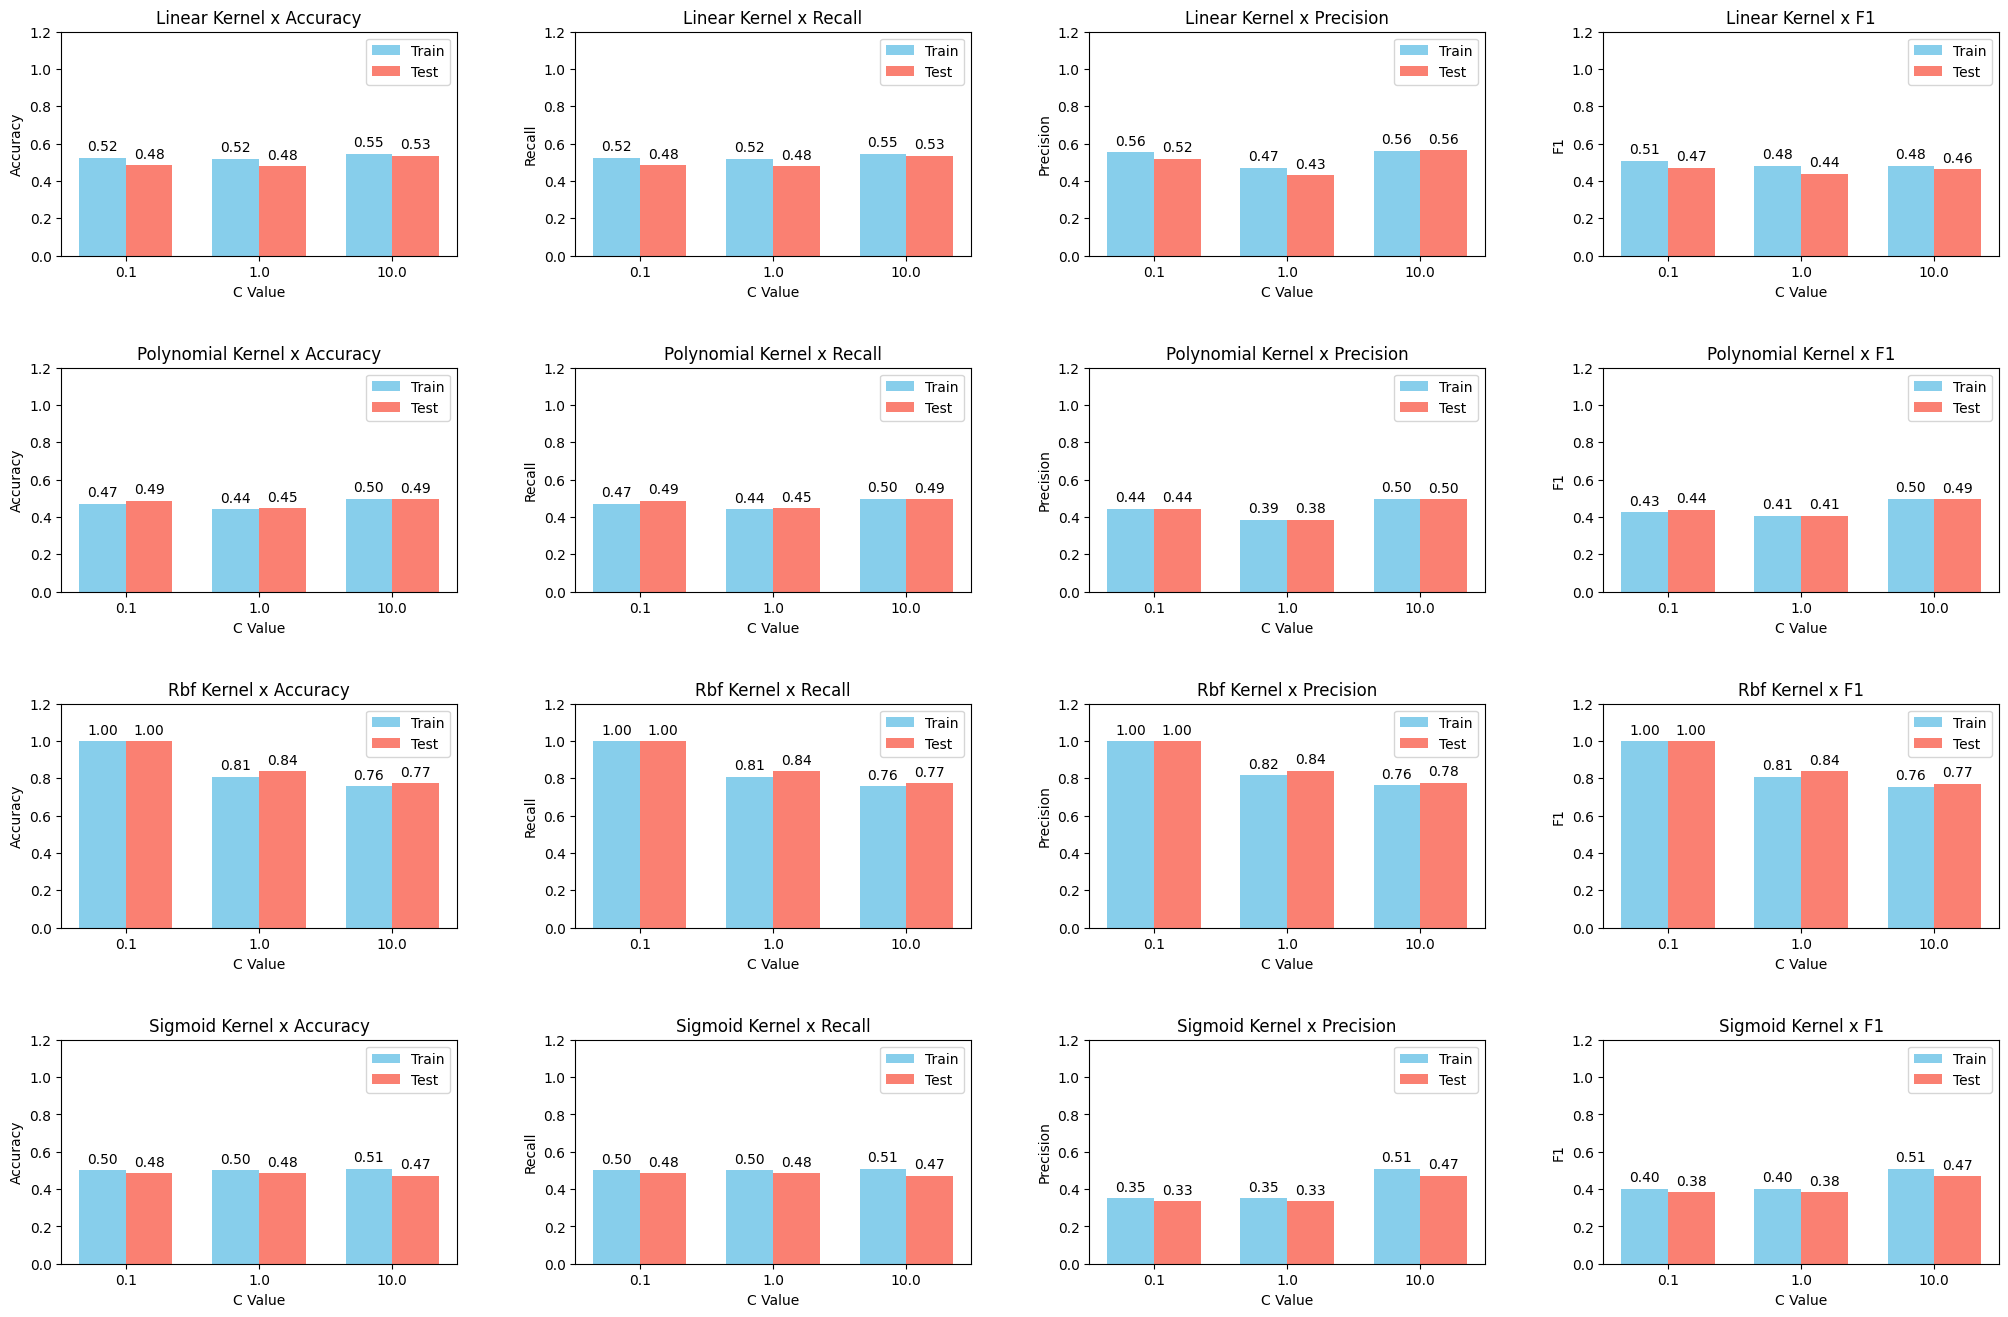

In [4]:
# load dataset
svm_experiment_path = "./data/svm_test.csv"
svm_df = pd.read_csv(svm_experiment_path)

# define the kernels and metrics to visualize
kernels = svm_df['Kernel'].unique()
metrics = ['Accuracy', 'Recall', 'Precision', 'F1']

# create subplots
fig, axes = plt.subplots(4, 4, figsize=(25, 16))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# define colors for train and test bars
colors = {'train': 'skyblue', 'test': 'salmon'}

# iterate over each kernel and metric
for i, kernel in enumerate(kernels):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        
        # filter data for the current kernel and metric
        kernel_data = svm_df[svm_df['Kernel'] == kernel]
        
        # prepare data for plotting
        c_values = [0.1, 1.0, 10.0]
        train_values = []
        test_values = []
        
        for c in c_values:
            train_val = kernel_data[(kernel_data['C'] == c) & (kernel_data['Split'] == 'train')][metric].values[0]
            test_val = kernel_data[(kernel_data['C'] == c) & (kernel_data['Split'] == 'test')][metric].values[0]
            train_values.append(train_val)
            test_values.append(test_val)
        
        # customize visualiations
        x = np.arange(len(c_values))
        width = 0.35

        # create plots
        train_bars = ax.bar(x - width/2, train_values, width, label='Train', color=colors['train'])
        test_bars = ax.bar(x + width/2, test_values, width, label='Test', color=colors['test'])
        
        # add labels and title
        ax.set_ylim(0, 1.2)
        ax.set_xticks(x)
        ax.set_xticklabels(c_values)
        ax.set_xlabel('C Value')
        ax.set_ylabel(metric)
        ax.set_title(f'{kernel.capitalize()} Kernel x {metric}')
        ax.legend()
        
        # improve readibility
        for bar in train_bars + test_bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

plt.show()

In [35]:
## Support Vector Machine (SVM)
class SVM:
    """Support Vector Machine implementation from scratch"""
    def __init__(self, kernel='linear', C=10, degree=3, gamma='auto'):
        self.kernel = kernel
        self.C = C
        self.degree = degree
        self.gamma = gamma
        self.alpha = None
        self.b = 0
        self.X_train = None
        self.y_train = None

    def _kernel_fn(self, x1, x2):
        if self.kernel == 'linear':
            return np.dot(x1, x2.T)
        elif self.kernel == 'poly':
            return (np.dot(x1, x2.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            if self.gamma == 'auto':
                gamma = 1.0 / x1.shape[1]
            else:
                gamma = self.gamma
            return np.exp(gamma * np.linalg.norm(x1[:, np.newaxis] - x2, axis=2)**2)
        elif self.kernel == 'sigmoid':
            return np.tanh(np.dot(x1, x2.T))
        else:
            raise ValueError("Unsupported kernel")

    def fit(self, X, y, max_iter=1000, tol=1e-3):
        n_samples, _ = X.shape
        self.X_train = X
        self.y_train = y

        #Initialize alpha
        self.alpha = np.zeros(n_samples)

        #Kernel matrix
        K = self._kernel_fn(X, X)

        #Simplified SMO
        for _ in range(max_iter):
            alpha_prev = np.copy(self.alpha)

            for i in range(n_samples):
                #Compute error for sample i
                Ei = np.sum(self.alpha * y * K[:, i]) + self.b - y[i]

                #Check KKT conditions
                if (y[i]*Ei < -tol and self.alpha[i] < self.C) or (y[i]*Ei > tol and self.alpha[i] > 0):
                    #Randomly select j != i
                    j = np.random.choice(list(set(range(n_samples)) - {i}))

                    #Compute error for sample j
                    Ej = np.sum(self.alpha * y * K[:, j]) + self.b - y[j]

                    #Save old alphas
                    alpha_i_old, alpha_j_old = self.alpha[i], self.alpha[j]

                    #Compute L and H bounds
                    if y[i] != y[j]:
                        L = max(0, self.alpha[j] - self.alpha[i])
                        H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                    else:
                        L = max(0, self.alpha[i] + self.alpha[j] - self.C)
                        H = min(self.C, self.alpha[i] + self.alpha[j])

                    if L == H:
                        continue

                    #Compute eta
                    eta = 2 * K[i,j] - K[i,i] - K[j,j]
                    if eta >= 0:
                        continue

                    #Update alpha j
                    self.alpha[j] = alpha_j_old - y[j] * (Ei - Ej) / eta

                    #Clip alpha j
                    self.alpha[j] = max(L, min(H, self.alpha[j]))

                    #Check for significant change
                    if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                        continue

                    #Update alpha i
                    self.alpha[i] = alpha_i_old + y[i]*y[j]*(alpha_j_old - self.alpha[j])

                    #Compute b
                    b1 = self.b - Ei - y[i]*(self.alpha[i]-alpha_i_old)*K[i,i] - y[j]*(self.alpha[j]-alpha_j_old)*K[i,j]
                    b2 = self.b - Ej - y[i]*(self.alpha[i]-alpha_i_old)*K[i,j] - y[j]*(self.alpha[j]-alpha_j_old)*K[j,j]

                    if 0 < self.alpha[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2

            # Check convergence
            if np.linalg.norm(self.alpha - alpha_prev) < tol:
                break

    def predict(self, X):
        K = self._kernel_fn(X, self.X_train)
        y_pred = np.sign(np.dot(K, self.alpha * self.y_train) + self.b)
        return y_pred

# Explain and report your choices of design and hyper-parameters.

**Design Choices**
The network architecture only has a single input layer due to the homework instructions of "Simple" MLP implementation. Despite the example provided in class including multiple activation functions, when you look below, an initial experiment was ran on the Circles Dataset of Sample 1000. Here I compared the accuracy, f1, recall, precision and run time for each of the different model configurations. Out of 324  configuration combinations majority of the performers used the sigmoid activation function (refer to dataframe below). Given this I did not adapt my code to modularly include other activation functions like ReLU and tanh. 

**Hyperparamter Choices**: In my experiment, Accuracy and Precision had the same top performer configuration: activation = sigmoid, hidden=100, lr=0.1, regularization=l2, lambda=0.1. Whereas for Recall and F1 had 17 (same for both) configurations as their top peformers. 3/17 instances included activation=relu but since the other hyperparameters: lr=0.1, regularization=l2	and lambda=0.1 (only variation being hidden sizes) were the same in all relu instances and majority of the Accuracy, Precision, Recall and F1 top performers, I decided to not include relu in the MLP class implementation. My intution is that the other hyperparameters likely influenced the higher comparative performance for the relu configurations that made it in the top 17, not the activation funciton itself. Since the majority of the configurations in Recall-F1 top performers use hidden_size=200 I decided to intialize the hyperparamter for hidden_size to 200. Similar to C paramter in SVM, a larger hidden input layer can lead to overfitting but since I focused my experiment analysis on the performance on test data, if the highest performers of testing splits use hidden_size=200, we can infer the additional model complexity actually improves generalizability. But in case that is not the case l2 norm can control for overfitting.

Best Model for Accuracy


,Activation,HiddenSize,LearningRate,Regularization,Lambda,Split,Accuracy,Recall,Precision,F1,Time
71,sigmoid,100,0.1,l2,0.1,test,0.525,0.47,0.52809,0.497354,0.0




There are 17 instances with the maximum value 1.0 for Recall
[27, 31, 35, 53, 61, 65, 77, 89, 91, 93, 97, 99, 105, 107, 143, 179, 215]


Best Model for Precision


,Activation,HiddenSize,LearningRate,Regularization,Lambda,Split,Accuracy,Recall,Precision,F1,Time
71,sigmoid,100,0.1,l2,0.1,test,0.525,0.47,0.52809,0.497354,0.0




There are 17 instances with the maximum value 0.6666666666666666 for F1
[27, 31, 35, 53, 61, 65, 77, 89, 91, 93, 97, 99, 105, 107, 143, 179, 215]




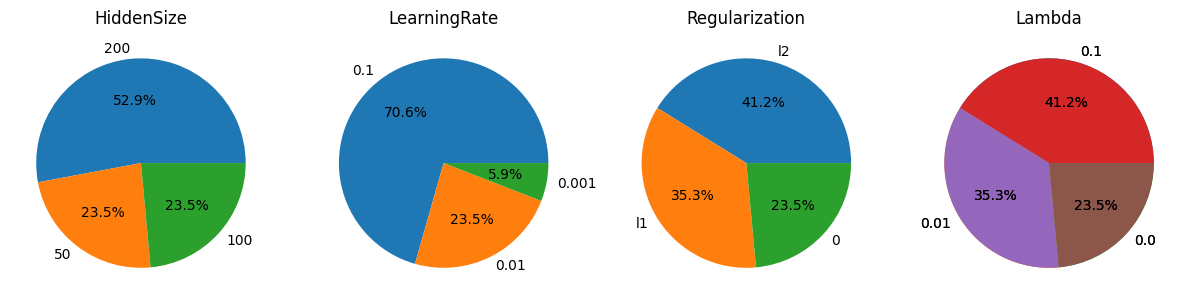

In [167]:
# load dataset
mlp_experiment_path = "./data/mlp_test.csv"
mlp_df = pd.read_csv(mlp_experiment_path)
mlp_df.fillna(0, inplace=True)
test_mlp = mlp_df[mlp_df['Split'] == 'test'] # only want to see best results for test data

def best_model(df, metric):
    max_val = df[metric].max()
    top = df[df[metric] == max_val]
    top_count = len(top)
    if top_count == 1:
        print(f'Best Model for {metric}')
        display(top)
    else:
        print(f'There are {top_count} instances with the maximum value {max_val} for {metric}')
        print(top.index.tolist())
        

for m in ['Accuracy', 'Recall', 'Precision', 'F1']:
    best_model(test_mlp, m)
    print('\n')


# look at marginal distributions for each hyperparameter to see most common occurrence
rec_f1_top = test_mlp[test_mlp['Recall'] == 1.0]
fig, axs = plt.subplots(1, 4, figsize=(12, 10))


hidden_counts = rec_f1_top['HiddenSize'].value_counts()
axs[0].pie(hidden_counts, labels=hidden_counts.index, autopct='%1.1f%%')
axs[0].set_title('HiddenSize')


lr_counts = rec_f1_top['LearningRate'].value_counts()
axs[1].pie(lr_counts, labels=lr_counts.index, autopct='%1.1f%%')
axs[1].set_title('LearningRate')


reg_counts = rec_f1_top['Regularization'].value_counts()
axs[2].pie(reg_counts, labels=reg_counts.index, autopct='%1.1f%%')
axs[2].set_title('Regularization')


lambda_counts = rec_f1_top['Lambda'].value_counts()
axs[3].pie(lambda_counts, labels=lambda_counts.index, autopct='%1.1f%%')
axs[3].set_title('Lambda')

lambda_counts = rec_f1_top['Lambda'].value_counts()
axs[3].pie(lambda_counts, labels=lambda_counts.index, autopct='%1.1f%%')
axs[3].set_title('Lambda')

plt.tight_layout()
plt.show()


In [7]:
class MLP:
    def __init__(self, hidden_size=200, learning_rate=0.1, epochs=1000, l2_lambda=0.01):
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.l2_lambda = l2_lambda  # L2 regularization strength
        self.weights1 = None
        self.weights2 = None
        self.bias1 = None
        self.bias2 = None
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def _cross_entropy_loss(self, y_true, y_pred, epsilon=1e-12):
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        N = y_pred.shape[0]
        return -np.sum(y_true * np.log(y_pred)) / N
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Convert labels to one-hot encoding
        n_classes = len(np.unique(y))
        y_onehot = np.eye(n_classes)[y]
        
        # Initialize weights
        self.weights1 = np.random.randn(n_features, self.hidden_size) * 0.01
        self.bias1 = np.zeros((1, self.hidden_size))
        self.weights2 = np.random.randn(self.hidden_size, n_classes) * 0.01
        self.bias2 = np.zeros((1, n_classes))
        
        for epoch in range(self.epochs):
            # Forward pass
            hidden = self._sigmoid(np.dot(X, self.weights1) + self.bias1)
            scores = np.dot(hidden, self.weights2) + self.bias2
            probs = self._softmax(scores)
            
            # Calculate loss with L2 regularization
            data_loss = self._cross_entropy_loss(y_onehot, probs)
            reg_loss = 0.5 * self.l2_lambda * (np.sum(self.weights1**2) + np.sum(self.weights2**2))
            total_loss = data_loss + reg_loss
            
            # if epoch % 100 == 0:
            #     print(f"Epoch {epoch}, Loss: {total_loss:.4f}")
            
            # Backward pass
            # Output layer gradient (cross-entropy + softmax derivative)
            dscores = (probs - y_onehot) / n_samples
            
            # Hidden layer gradient
            dhidden = np.dot(dscores, self.weights2.T)
            dhidden *= self._sigmoid_derivative(hidden)
            
            # Add L2 regularization gradient
            dW2 = np.dot(hidden.T, dscores) + self.l2_lambda * self.weights2
            db2 = np.sum(dscores, axis=0, keepdims=True)
            dW1 = np.dot(X.T, dhidden) + self.l2_lambda * self.weights1
            db1 = np.sum(dhidden, axis=0, keepdims=True)
            
            # Update weights
            self.weights2 -= self.learning_rate * dW2
            self.bias2 -= self.learning_rate * db2
            self.weights1 -= self.learning_rate * dW1
            self.bias1 -= self.learning_rate * db1
    
    def predict(self, X):
        hidden = self._sigmoid(np.dot(X, self.weights1) + self.bias1)
        scores = np.dot(hidden, self.weights2) + self.bias2
        return np.argmax(scores, axis=1)


## Explain which metrics you will use for performance evaluation.

For classification popular evaluation metrics include: accuracy, f1 score, recall, precision and AUC.
1. AUC (Area Under the Curve) is a valuable metric that summarizes the trade-off between true positive rate (TPR) and false positive rate (FPR) across all possible classification thresholds. By plotting TPR versus FPR in a receiver operating characteristic (ROC) curve, we can visualize how well a model distinguishes between positive and negative classes. The AUC quantifies this performance, with higher values indicating better discrimination, and a perfect model achieving an AUC of 1.
2. The F1 score combines precision and recall into a single metric using their harmonic mean, which penalizes extreme imbalances more effectively than the arithmetic mean. This is especially useful when dealing with low-prevalence classes, where high recall alone can be misleading. Although we can presume that the sklearn libraries create statistical equivalent prevalence for each class, without calculating class priors as part of my analysis I wanted to be thorough in my evaulation.
3. Accuracy is a generally applicable metric across different types of ML models to get a knee jerk understanding of how often a prediction was correct which makes comparison and explainability easier for different audiences and contexts.

In [77]:
def evaluate_model(y, y_hat, cat='binary'):
    """Evaluate model performance"""
    accuracy = np.mean(y_hat == y)

    true_positives = np.sum((y == 1) & (y_hat == 1))
    false_negatives = np.sum((y == 1) & (y_hat == -1))
    false_positives = np.sum((y == -1) & (y_hat == 1))

    # ignore the error that comes up with SVM RBF kernel
    with np.errstate(divide='ignore', invalid='ignore'):
      recall = true_positives / (true_positives + false_negatives)
      precision = true_positives / (true_positives + false_positives)
      f1 = (2 * (precision * recall)) / (precision + recall)

    if cat=='multi':
        roc_auc = None # 'ovr' implementation not working

    else:
        roc_auc = roc_auc_score(y, y_hat)

    return accuracy, recall, precision, f1, roc_auc

In [9]:
def k_fold_cross_validation(X, y, model, k=5):
    n_samples = X.shape[0]
    fold_size = n_samples // k

    # initialize metrics
    test_accuracies = []
    test_recall_scores = []
    test_precision_scores = []
    test_f1_scores = []
    test_roc_scores = []

    train_accuracies = []
    train_recall_scores = []
    train_precision_scores = []
    train_f1_scores = []
    train_roc_scores = []



    for i in range(k):

        # Split data
        test_indices = range(i*fold_size, (i+1)*fold_size)
        train_indices = list(set(range(n_samples)) - set(test_indices))

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Train and evaluate
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        test_accuracy, test_recall, test_precision, test_f1, test_roc_auc = evaluate_model(y_test, y_pred_test)
        train_accuracy, train_recall, train_precision, train_f1, train_roc_auc = evaluate_model(y_train, y_pred_train)



        # append results
        test_accuracies.append(test_accuracy)
        test_recall_scores.append(test_recall)
        test_precision_scores.append(test_precision)
        test_f1_scores.append(test_f1)
        test_roc_scores.append(test_roc_auc)
        train_accuracies.append(train_accuracy)
        train_recall_scores.append(train_recall)
        train_precision_scores.append(train_precision)
        train_f1_scores.append(train_f1)
        train_roc_scores.append(train_roc_auc)


    # return average metrics
    test_acc_avg = np.mean(test_accuracies)
    test_recall_avg = np.mean(test_recall_scores)
    test_precision_avg = np.mean(test_precision_scores)
    test_f1_avg = np.mean(test_f1_scores)
    test_roc_auc_avg = np.mean(test_roc_scores)

    train_acc_avg = np.mean(train_accuracies)
    train_recall_avg = np.mean(train_recall_scores)
    train_precision_avg = np.mean(train_precision_scores)
    train_f1_avg = np.mean(train_f1_scores)
    train_roc_auc_avg = np.mean(train_roc_scores)

    results = {
        'test_accuracy': test_acc_avg,
        'test_recall': test_recall_avg,
        'test_precision': test_precision_avg,
        'test_f1': test_f1_avg,
        'test_roc_auc': test_roc_auc_avg,
        'train_accuracy': train_acc_avg,
        'train_recall': train_recall_avg,
        'train_precision': train_precision_avg,
        'train_f1': train_f1_avg,
        'train_roc_auc': train_roc_auc_avg
    }

    return results

In [10]:
# Generate datasets (smaller sample size for runtime during code walk)
datasets = {
     'Moons 1000': make_moons(n_samples=1000, noise=0.2, random_state=42),
     'Moons 10000': make_moons(n_samples=10000, noise=0.2, random_state=42),
     'Circles 1000': make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42),
     'Circles 10000': make_circles(n_samples=10000, noise=0.1, factor=0.5, random_state=42)
}

In [11]:
# Set up figure parameters
plt.figure(figsize=(16, 12))
colors = ['#ff9999', '#66b3ff']
markers = ['o', 'x']

<Figure size 1600x1200 with 0 Axes>

In [12]:
# Function to visualize dataset
def visualize_dataset(X, y, title, filename):
    plt.figure(figsize=(8, 6))
    for i in range(2):  # Two classes
        plt.scatter(X[y == i, 0], X[y == i, 1],
                   c=colors[i], marker=markers[i],
                   label=f'Class {i}', alpha=0.7)

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'visualizations/{filename}.png', dpi=300)
    plt.close()
    print(f"Saved visualization: {filename}.png")

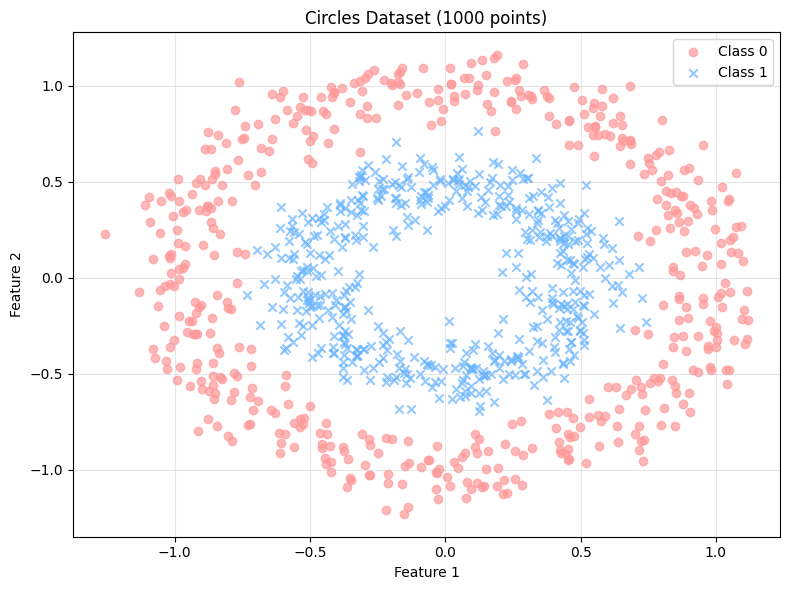

Saved visualization: circles_1k.png


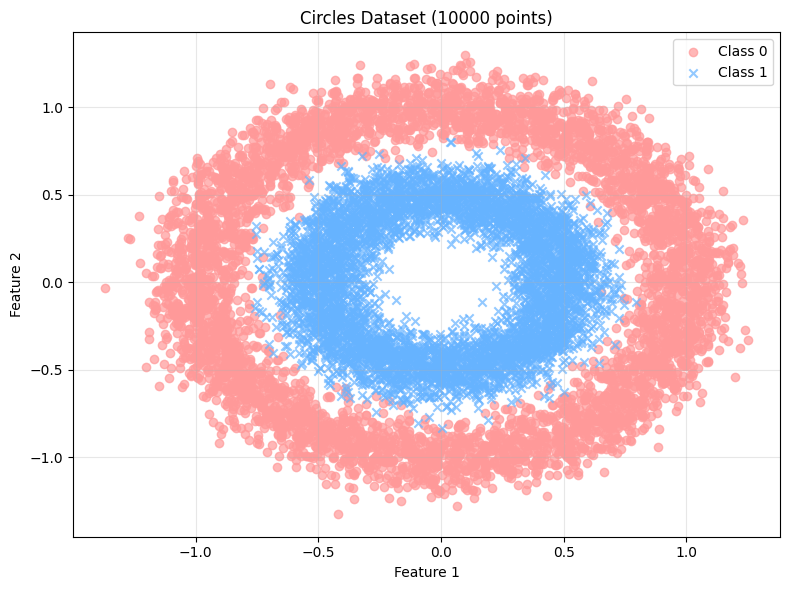

Saved visualization: circles_10k.png


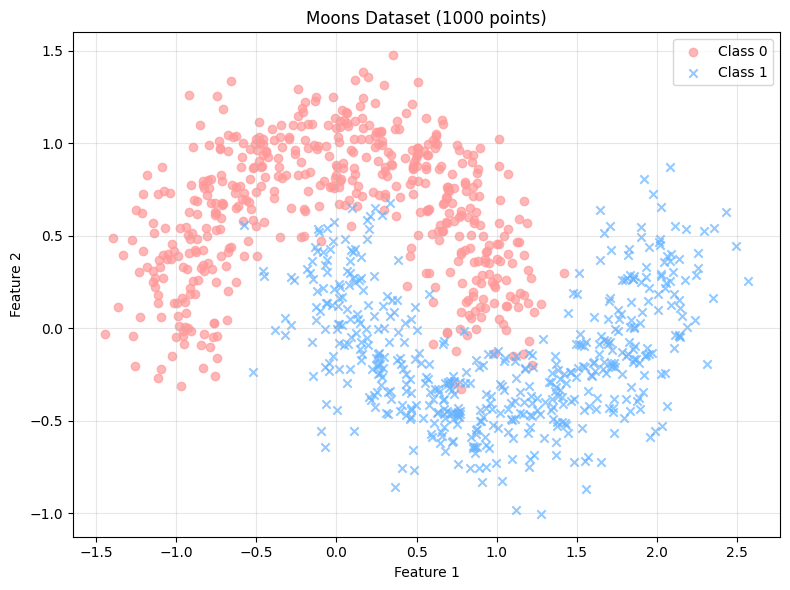

Saved visualization: moons_1k.png


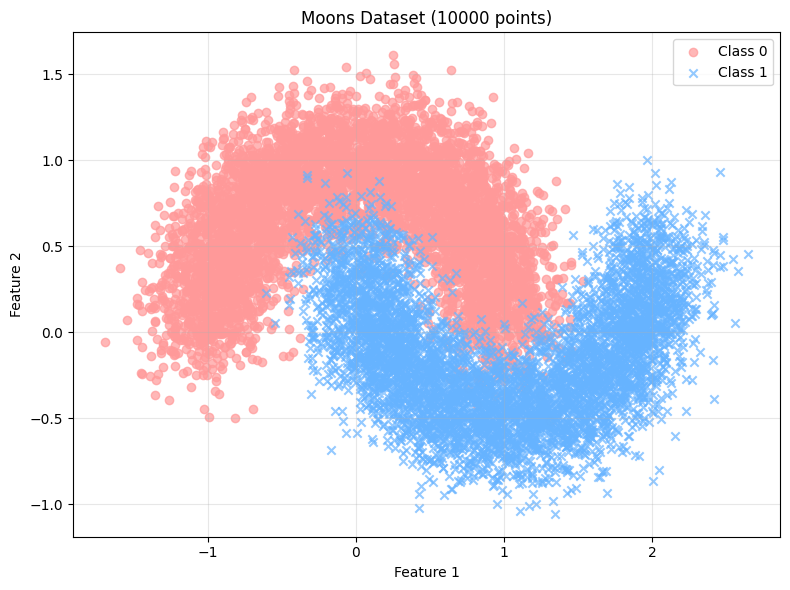

Saved visualization: moons_10k.png


In [13]:
# Half-circles datasets
X_half_circles_1k, y_half_circles_1k = datasets['Circles 1000']
visualize_dataset(X_half_circles_1k, y_half_circles_1k,
                 'Circles Dataset (1000 points)',
                 'circles_1k')

X_half_circles_10k, y_half_circles_10k = datasets['Circles 10000']
visualize_dataset(X_half_circles_10k, y_half_circles_10k,
                 'Circles Dataset (10000 points)',
                 'circles_10k')

# Moons datasets
X_moons_1k, y_moons_1k = datasets['Moons 1000']
visualize_dataset(X_moons_1k, y_moons_1k,
                 'Moons Dataset (1000 points)',
                 'moons_1k')

X_moons_10k, y_moons_10k = datasets['Moons 10000']
visualize_dataset(X_moons_10k, y_moons_10k,
                 'Moons Dataset (10000 points)',
                 'moons_10k')

In [14]:
# Evaluate models
bin_clf_results = []
models = {
    'MLP': MLP(),
    'SVM Linear': SVM(kernel='linear'),
    'SVM Poly': SVM(kernel='poly'),
    'SVM RBF': SVM(kernel='rbf'),
    'SVM Sigmoid': SVM(kernel='sigmoid')
}

for name, (X, y) in datasets.items():
    y = np.where(y == 0, -1, 1)  # Convert to -1, 1 for SVM instead of 0 to 1
    for model_name, model in models.items():
        start = time.time()
        evaluation = k_fold_cross_validation(X, y, model)
        runtime = time.time() - start
        bin_clf_results.append({
            'Dataset': name,
            'Model': model_name,
            'Test Accuracy': evaluation['test_accuracy'],
            'Test Recall': evaluation['test_recall'],
            'Test Precision': evaluation['test_precision'],
            'Test F1': evaluation['test_f1'],
            'Test ROC AUC': evaluation['test_roc_auc'],
            'Train Accuracy': evaluation['train_accuracy'],
            'Train Recall': evaluation['train_recall'],
            'Train Precision': evaluation['train_precision'],
            'Train F1': evaluation['train_f1'],
            'Train ROC AUC': evaluation['train_roc_auc'],
            'Run Time': runtime
})

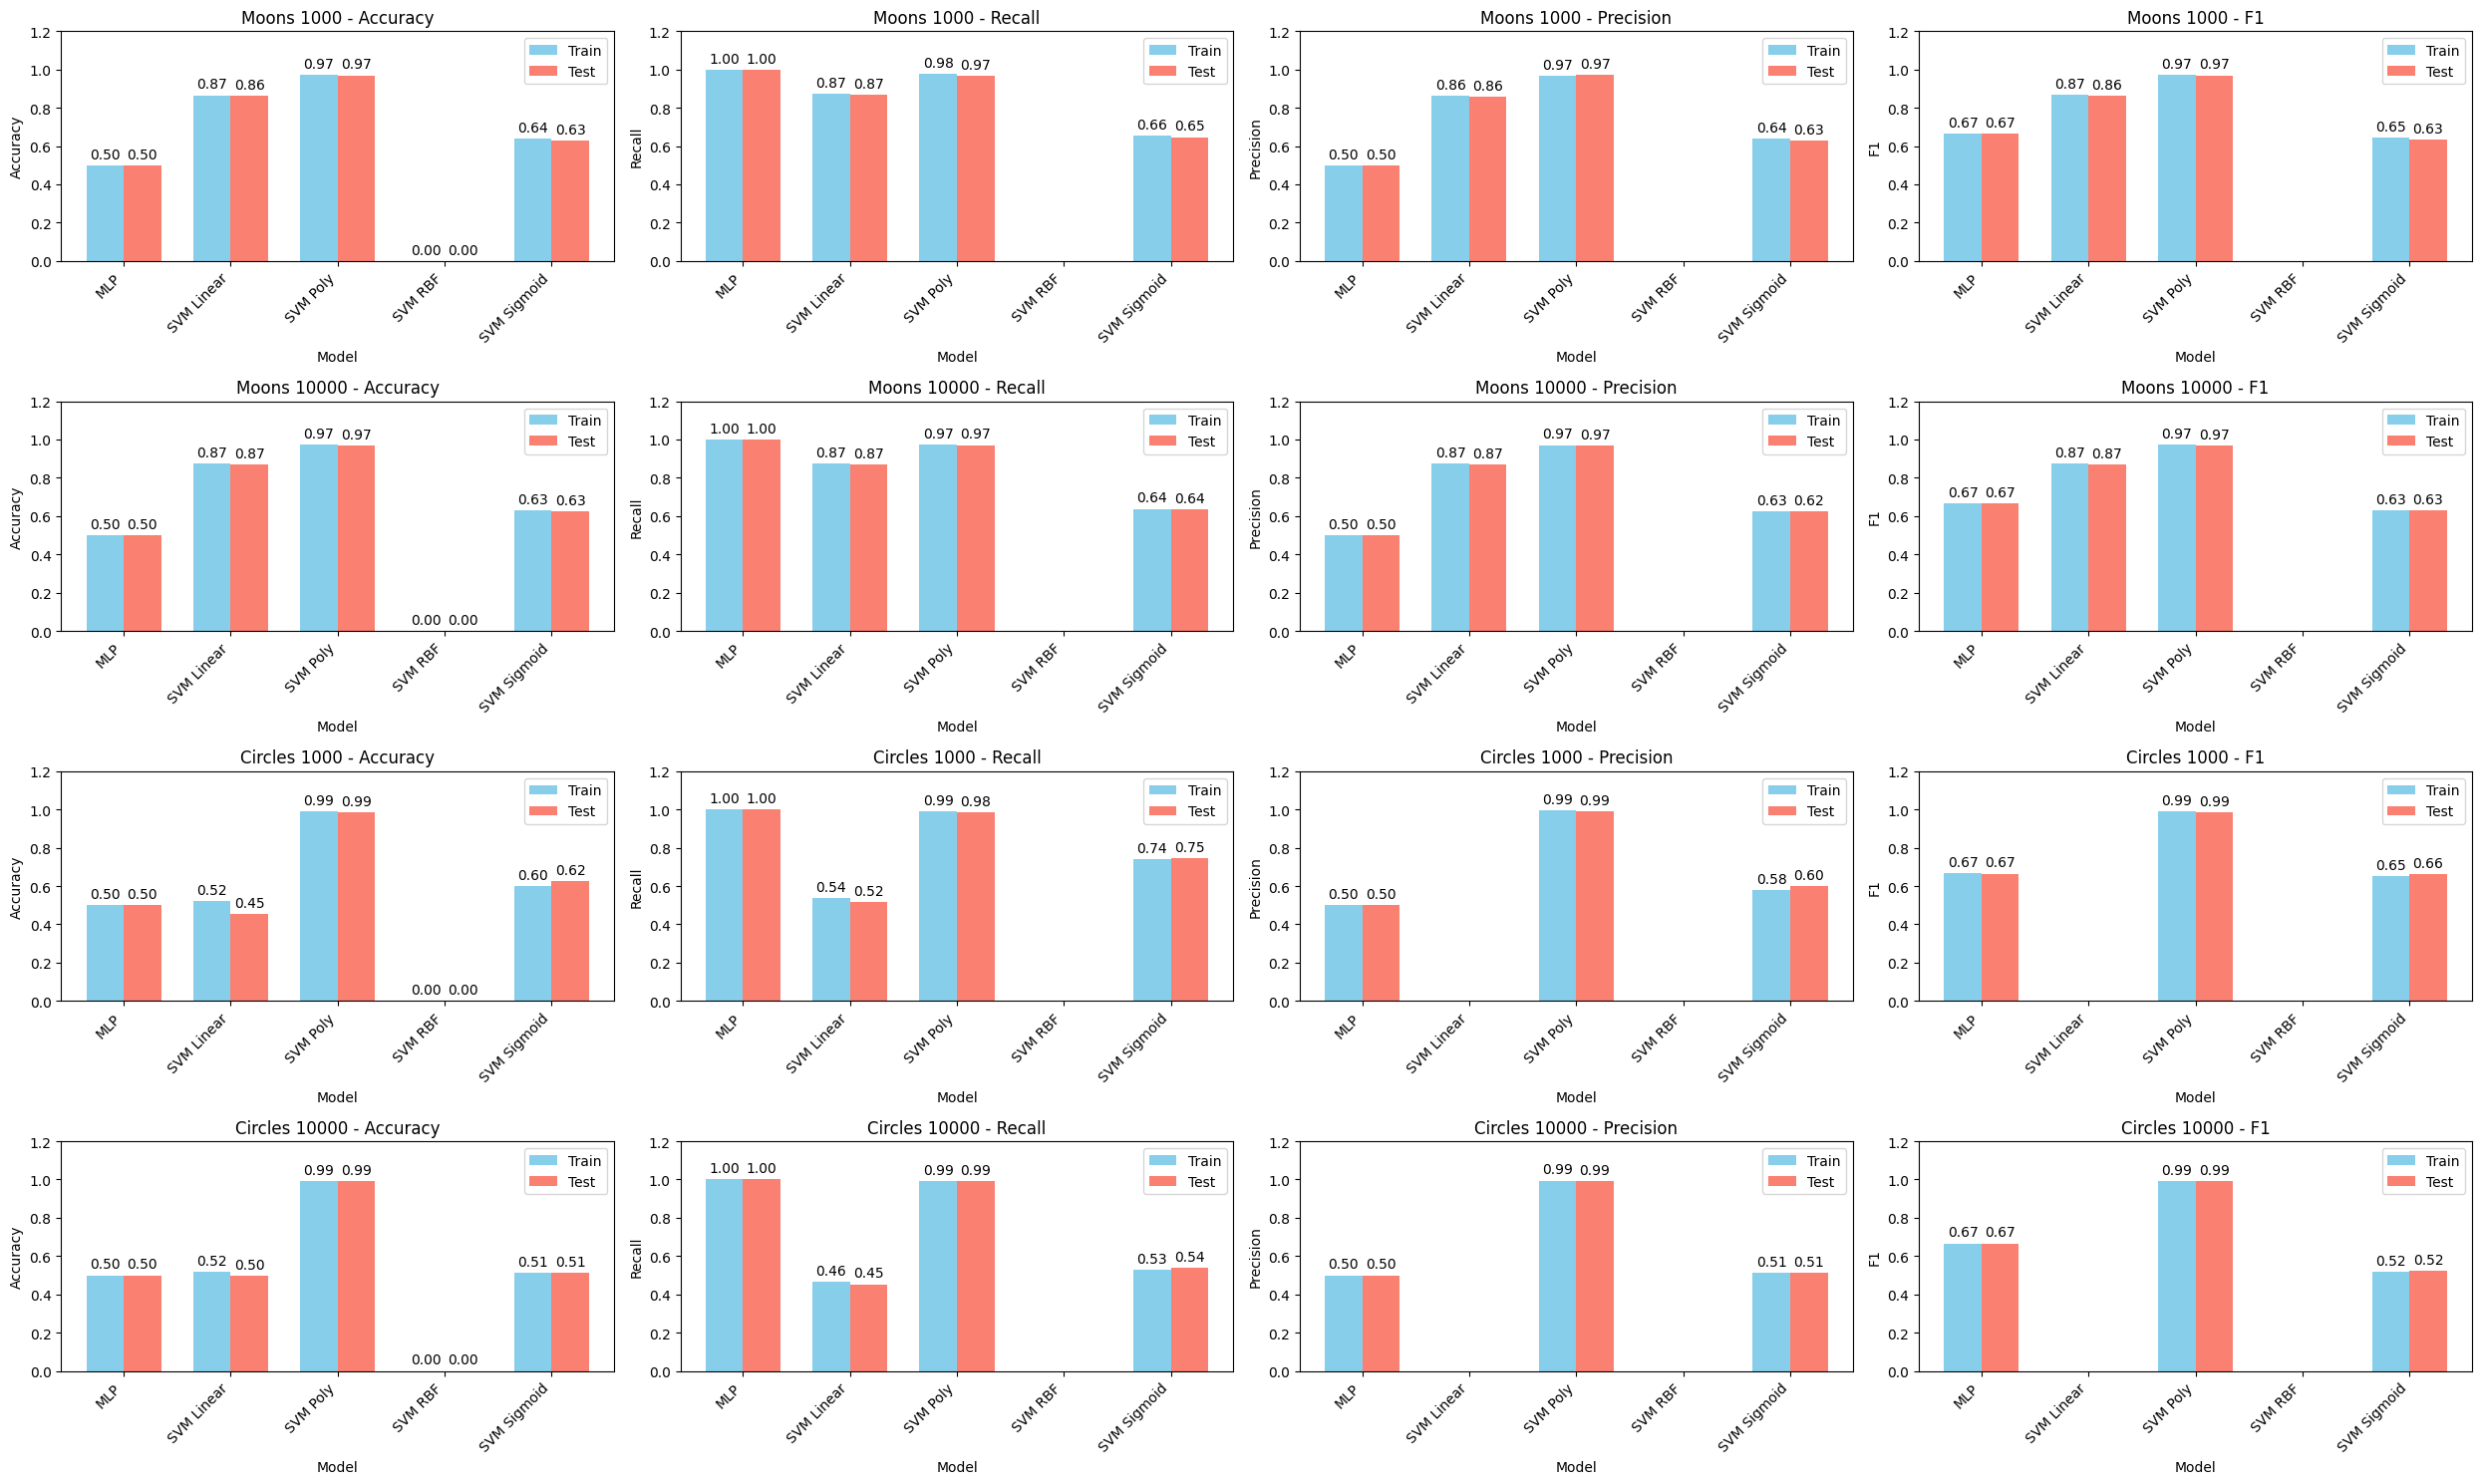

In [34]:
# Display and save results
bin_clf_results_df = pd.DataFrame(bin_clf_results)
bin_clf_results_df = bin_clf_results_df.fillna(-1) # fill in null values for rbf kernel
bin_clf_results_df.to_csv('svm-mlp-bin-clf-results.csv')


# Get unique datasets and models
datasets = bin_clf_results_df['Dataset'].unique()
models = bin_clf_results_df['Model'].unique()

# Define the base metrics to visualize
base_metrics = ['Accuracy', 'Recall', 'Precision', 'F1']

# Create subplots based on the number of unique datasets and base metrics
fig, axes = plt.subplots(len(datasets), len(base_metrics), figsize=(25, 15))
plt.subplots_adjust(hspace=0.7, wspace=0.3)

# Ensure axes is always a 2D array, even if there's only one dataset or base_metric
if len(datasets) == 1 and len(base_metrics) == 1:
    axes = np.array([[axes]])
elif len(datasets) == 1:
    axes = axes[np.newaxis, :]
elif len(base_metrics) == 1:
    axes = axes[:, np.newaxis]

# Define colors for train and test bars
colors = {'train': 'skyblue', 'test': 'salmon'}

# Iterate over each dataset and base metric
for i, dataset in enumerate(datasets):
    for j, metric in enumerate(base_metrics):
        ax = axes[i, j]

        # Filter data for the current dataset
        dataset_data = bin_clf_results_df[bin_clf_results_df['Dataset'] == dataset]

        train_values = []
        test_values = []

        for model in models:
            # Get train and test values for the current model and metric
            train_val_row = dataset_data[dataset_data['Model'] == model]
            if not train_val_row.empty:
                train_values.append(train_val_row[f'Train {metric}'].values[0])
                test_values.append(train_val_row[f'Test {metric}'].values[0])
            else:
                train_values.append(np.nan)
                test_values.append(np.nan)

        # Customize visualizations
        x = np.arange(len(models))
        width = 0.35

        # Create plots, handling NaNs
        train_bars = ax.bar(x - width/2, train_values, width, label='Train', color=colors['train'])
        test_bars = ax.bar(x + width/2, test_values, width, label='Test', color=colors['test'])

        # Add labels and title
        ax.set_ylim(0, 1.2) # Keeping the same y-limit
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha='right') # Rotate labels for better readability
        ax.set_xlabel('Model')
        ax.set_ylabel(metric)
        ax.set_title(f'{dataset.replace("_", " ").title()} - {metric}') # Format title for readability
        ax.legend()

        # Improve readability by adding value annotations
        for bar in train_bars + test_bars:
            height = bar.get_height()
            if not np.isnan(height) and height >= 0: # Only annotate if not NaN and non-negative
                ax.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [31]:
bin_clf_results_df[['Model', 'Run Time']].sort_values('Run Time').groupby('Model').mean()

,Run Time
Model,
MLP,36.828812
SVM Linear,474.462709
SVM Poly,468.962808
SVM RBF,26.930089
SVM Sigmoid,192.624684


## Comparative Analysis of Results

Note: instructions specific a table but for the purpose of readibility and analysis, I felt bar charts were the better approach to compare results across model configurations.

### Best Model Performance
Across all datasets, the Support Vector Machine (SVM) with a Polynomial kernel consistently emerged as the best performer. This is likely due to its inherent ability to capture curved boundaries and complex, non-linear relationships within the data. The "circles" dataset inherently exhibits a circular relationship ($x^2 + y^2 = r^2$) and the "moon" dataset displays a parabolic-like separation. The Polynomial kernel, with its capacity to incorporate quadratic terms, is well-suited to model such geometric structures, explaining its superior performance.

The Linear SVM performed well on the "moon" datasets, regardless of size, despite the relationship being non-linear. For futre iterations visualizing the decision bounadry can provide intuition as to why, especially when compared to its poor performance of the "circles" dataset, where both are inherently non-linear. Though these results were consistent with experimental expectations for a linear model on such data.

Contrary to expectations based on hyperparameter configuration experiments, the RBF SVM performed poorly on the larger datasets, often yielding no meaningful values. This is almost certainly due to an inappropriately small gamma value. The gamma was set as the reciprocal of the number of input features (0.5), which was sufficient for smaller datasets (e.g., 100 points) used in initial experiments. However, for larger datasets (1000 and 10000 points), a fixed small gamma makes the kernel highly vulnerable to poor hyperparameter tuning, leading to a localized decision boundary that fails to generalize. While RBF kernels are typically powerful in capturing complex non-linear decision boundaries, their performance is highly sensitive to the gamma parameter. A larger gamma value is likely needed for these larger datasets and will be implemented in the multi label and multi class SVM applications.

The Sigmoid kernel generally exhibited poor performance. This is attributed to its high sensitivity to the choice of its alpha and coef0 parameters, indicating a need for more rigorous parameter tuning and experimenting.

The MLP consistently excelled at predicting positive classes across all datasets, achieving the highest recall. The reason for this specific strength in predicting positive classes, given the visual shape of "Class 1" in each dataset, is not immediately clear and warrants further investigation into the MLP's internal decision-making process.


### Effect of More Data on Performance:

Generally, there was consistent performance across models, with a few notable discrepancies where larger datasets negatively impacted performance. Accuracy, recall, precision, and F1-score all deteriorated for SVM Sigmoid with larger datasets. This suggests that the model became more prone to misclassification or was unable to generalize as effectively with more data. The recall for SVM Linear was also worse in larger datasets.

### Role of Cross-Validation in Model Evaluation:

The role of cross-validation was likely highly beneficial due to the mathematical intution and vulnerability of overfitting for many of these models. For kernel functions like the Polynomial kernel that can be sensitive to parameter choices, cross-validation is essential for robust tuning.

### Cross-validation's utility would have been significantly enhanced by:

Instead of just mean performance metrics, a breakdown for each fold would provide a more granular view of model consistency and identify outlier folds and their data characteristics. Incorporating t-tests to analyze the statistical significance of differences between metrics across folds, and homogeneity of variance tests to assess if training and test data splits across all 5 folds are statistically different, would provide stronger evidence for where model training could be improved and if observed performance differences are truly meaningful.
Cross-validation typically helps improve Sigmoid kernel functions, but this was not observed in this case, further suggesting that the initial parameter choices for the Sigmoid kernel were severely suboptimal.


### Computational Cost Comparison:

The computational cost of the methods, from longest to shortest, was: SVM Polynomial, SVM Linear, SVM Sigmoid, MLP and RBF. There was a direct positive correlation between the computational time spent on testing and training and the model's performance. This suggests that more complex models or those requiring more extensive computations (like SVMs with certain kernels) often yielded better results, indicating a trade-off between computational expense and model effectiveness.

In [ ]:
# metrics = ['Test Accuracy', 'Train Accuracy', 'Test Recall', 'Train Recall', 'Test Precision',
#            'Train Precision', 'Test F1', 'Train F1', 'Test ROC AUC', 'Train ROC AUC']

# for data in datasets.keys():
#     print(f'Model Results for {data}')
#     pivot_table = bin_clf_results_df[bin_clf_results_df['Dataset'] == data]
#     print(pivot_table.set_index('Model')[metrics].T)
#     print('\n\n')

# Question 2: SVM for multi-class and multi-label classification

## Pseudocode for Muti-Label Classification

    FUNCTION MultiLabelSVM(kernel='linear', C=1.0)
      SET kernel
      SET C
      INITIALIZE empty list classifiers
    
      FUNCTION fit(X, Y)
        GET number of classes from Y
        CLEAR classifiers list
    
        FOR each class i in number of classes
          CREATE new SVM with kernel and C
          EXTRACT labels for class i from Y
          CONVERT labels: 0 to -1, 1 stays 1
          TRAIN SVM with X and converted labels
          ADD trained SVM to classifiers list
        END FOR
      END FUNCTION
    
      FUNCTION predict(X)
        INITIALIZE empty list predictions
    
        FOR each trained SVM in classifiers
          PREDICT labels for X
          CONVERT predictions: -1 to 0, 1 stays 1
          ADD converted predictions to predictions list
        END FOR
    
        RETURN combined predictions for all classes
      END FUNCTION
    END FUNCTION


In [18]:
# # load arff files
# with open('/kaggle/input/plantgo-csv/PlantGO-test.csv', 'r') as f:
#     arff_test = arff.load(f)
#     np_plant_test = np.array(arff_test['data'])
#     f.close()

# with open('/kaggle/input/plantgo-random-train-test/PlantGO-train.arff', 'r') as f:
#     arff_train = arff.load(f)
#     np_plant_train = np.array(arff_train['data'])
#     f.close()


# arff_test_df = pd.DataFrame(arff_test['data'], columns=[attr[0] for attr in arff_test['attributes']])
# arff_test_df.to_csv('PlantGo-test.csv')
# arff_train_df = pd.DataFrame(arff_train['data'], columns=[attr[0] for attr in arff_train['attributes']])
# arff_train_df.to_csv('PlantGo-train.csv')

In [97]:
class MultiLabelSVM:
    """One-vs-Rest SVM for multi-label classification"""
    def __init__(self, kernel='poly', gamma=500, C=10):
        self.kernel = kernel
        self.C = C
        self.classifiers = []
        self.gamma = gamma

    def fit(self, X, Y):
        n_classes = Y.shape[1]
        self.classifiers = []

        for i in range(n_classes):
            svm = SVM(kernel=self.kernel, gamma=self.gamma, C=self.C)
            y = Y[:, i]
            y = np.where(y == 0, -1, 1)  # Convert to -1, 1
            svm.fit(X, y)
            self.classifiers.append(svm)

    def predict(self, X):
        predictions = []
        for svm in self.classifiers:
            pred = svm.predict(X)
            pred = np.where(pred == -1, 0, 1)  # Convert back to 0, 1
            predictions.append(pred)
        return np.column_stack(predictions)

In [94]:
def load_plantgo():

    plant_test_data = pd.read_csv('./data/plantgo_test.csv', index_col=0)
    plant_train_data = pd.read_csv('./data/plantgo_train.csv', index_col=0)
    
    feature_cols = plant_test_data.columns[:-12]
    target_cols = plant_test_data.columns[-12:]

    X_train = np.array(plant_train_data[feature_cols])
    y_train = np.array(plant_train_data[target_cols])
    X_test = np.array(plant_test_data[feature_cols])
    y_test = np.array(plant_test_data[target_cols])

    return X_train, y_train, X_test, y_test

In [95]:
# Calculate Hamming loss
def hamming_loss(Y_true, Y_pred):
    return np.mean(np.not_equal(Y_true, Y_pred))

## What are the metrics you can use for evaluation of your model? Why you chose those specific metrics?

When evaluating my SVM Multilabel Classifier with an RBF kernel, I focused on two key metrics: confusion matrices per label and Hamming loss. I chose these because they provide a comprehensive view of the model's performance, offering both a granular look at individual label predictions and an overall measure of error across all labels. Hamming loss provides a high-level view of the model's overall label prediction accuracy, indicating how "wrong" the model is across all labels. Simultaneously, the confusion matrices for each label delve into the specifics, revealing which types of errors are most frequent for each class. This dual approach helps me understand both the magnitude of the errors (Hamming loss) and the nature of the errors (per-label confusion matrices), guiding me effectively in refining my multilabel classification model.

By examining these metrics for each label, I can understand which types of errors (false positives or false negatives) are most prevalent for specific classes. This detailed breakdown is crucial for targeted improvements during future model training.

In multilabel classification, Hamming loss allows more robustness compared to zero-one loss by not penalizing a prediction if all predicted labels don't perfectly match the true values. It does this by calculating the proportion of labels that are incorrectly predicted across all samples and all labels.

This metric works in conjunction with the per-label confusion matrices by providing an overall summary of the model's error rate at the individual label level. It gives me a clear overview of how many labels, on average, the model got wrong, regardless of the specific label.

PlantGO dataset loaded successfully
Training data shape: (656, 3091), Labels shape: (656, 12)
Multi-label Hamming Loss: 0.05227743271221532


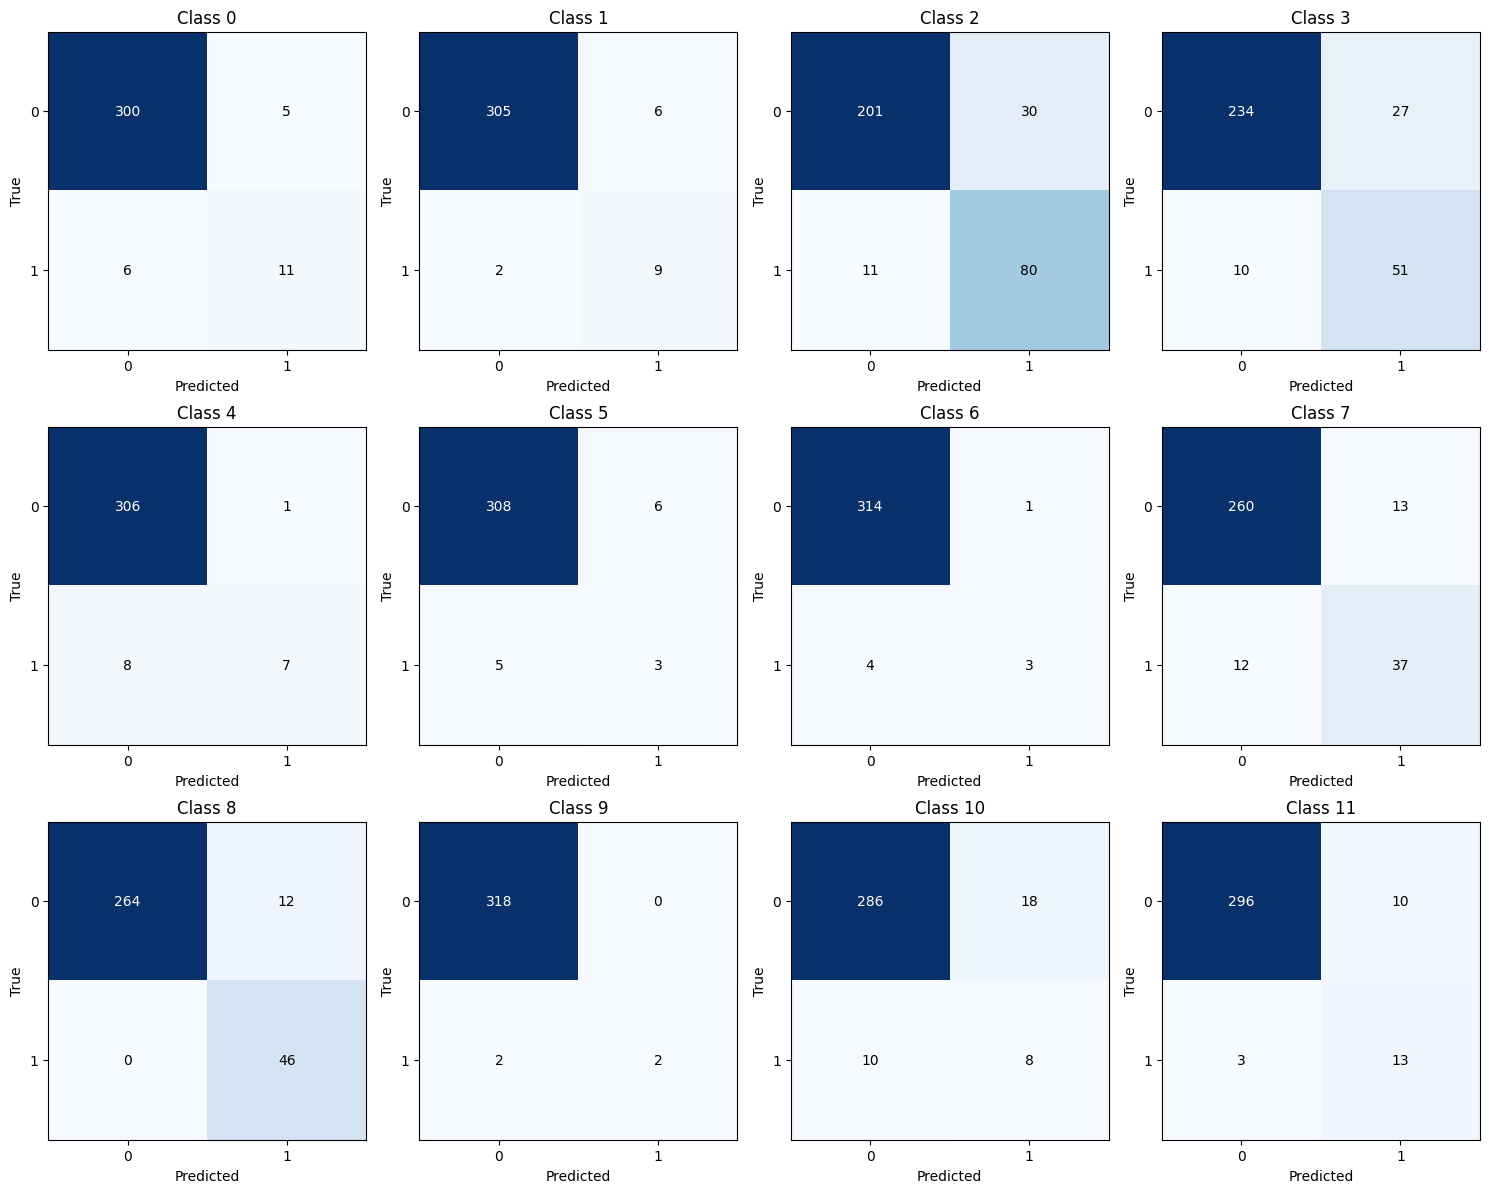

In [98]:
# Multi-label classification with PlantGO
try:
    X_train, Y_train, X_test, Y_test = load_plantgo()
    print("PlantGO dataset loaded successfully")
    print(f"Training data shape: {X_train.shape}, Labels shape: {Y_train.shape}")

    ml_svm = MultiLabelSVM()
    ml_svm.fit(X_train, Y_train)
    Y_pred = ml_svm.predict(X_test)

    print("Multi-label Hamming Loss:", hamming_loss(Y_test, Y_pred))

    mcm = multilabel_confusion_matrix(Y_test, Y_pred)

    # Plot each matrix
    label_count = len(mcm)
    cols = 4
    rows = ceil(label_count / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))  # Adjusted height based on rows
    
    # Flatten axes array for easier iteration if it's 2D
    axes = axes.ravel() if rows > 1 else axes
    
    for i, (cm, ax) in enumerate(zip(mcm, axes)):
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(f'Class {i}')
        for x in range(2):
            for y in range(2):
                ax.text(y, x, str(cm[x, y]),
                        ha='center', va='center',
                        color='white' if cm[x, y] > cm.max() / 2 else 'black')
    
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    
    # Hide any unused subplots
    for j in range(i+1, rows*cols):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error in multi-label classification: {e}")

## Report the result of your algorithm on your proposed metrics.

My initial attempts to use a Multi-Label SVM with an RBF kernel yielded consistently poor results, with a Hamming Loss of 0.911 across all experiments with different gamma values (0.5, 5, 50, 500, 500). This high Hamming Loss (where lower is better) indicates that the model was making significant errors in predicting labels. A closer look at the confusion matrices revealed the core issue: the model never predicted '0' for any of the labels, regardless of the true class. This is particularly problematic since Class '0' held the largest class prior for each label and constituted the majority of the dataset. Essentially, the RBF kernel was failing to identify the dominant class, leading to a severely biased and ineffective model.

Given the struggles with the RBF kernel, I decided to pivot to the Polynomial kernel, which had demonstrated strong performance in earlier iterations of my analysis. This decision proved to be highly effective. The Multi-Label SVM with the Polynomial kernel achieved a significantly lower Hamming Loss of 0.052, a substantial improvement over the RBF kernel's 0.911.

The improved performance is further corroborated by examining the confusion matrices for the Polynomial kernel. These matrices show a marked reduction in False Positive Rates (Type I errors). This means the model is much better at correctly identifying negative instances, which was the RBF kernel's critical failure point. The Polynomial kernel's ability to capture complex, non-linear relationships, as observed in previous experiments, likely contributed to its success in accurately differentiating between classes in this multi-label context. Whereas RBF is clearly highly sensitive to hyperparamter tuning.


<div style="text-align: center">
    <img src="../visualizations/ml-svm-rbf.png" width=700 />
</div>


## Pseudocode for Muti-Class Classification
    
    FUNCTION MultiClassSVM(kernel='rbf', C=1.0)
      SET kernel
      SET C
      INITIALIZE empty dictionary classifiers
      INITIALIZE classes as None
    
      FUNCTION fit(X, y)
        FIND unique classes in y
        SET classes to unique classes
        GET number of classes
    
        FOR each class i from 0 to number of classes - 1
          FOR each class j from i+1 to number of classes - 1
            CREATE new SVM with kernel and C
            SELECT samples from X and y where label is class i or class j
            CONVERT labels: class i to 1, class j to -1
            TRAIN SVM on selected samples and converted labels
            STORE trained SVM in classifiers dictionary with key (i, j)
          END FOR
        END FOR
      END FUNCTION
    
      FUNCTION predict(X)
        CREATE votes matrix with zeros for each sample and each class
    
        FOR each classifier key (i, j) and SVM in classifiers
          PREDICT labels for X using SVM
          INCREMENT votes for class i where prediction is 1
          INCREMENT votes for class j where prediction is -1
        END FOR
    
        RETURN class with highest vote count for each sample
      END FUNCTION
    END FUNCTION


In [88]:
class MultiClassSVM:
    """One-vs-One SVM for multi-class classification"""
    def __init__(self, kernel='rbf', gamma=50, C=10):
        self.kernel = kernel
        self.C = C
        self.classifiers = {}  # (class1, class2) -> SVM
        self.classes = None
        self.gamma = gamma

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Train one classifier for each pair
        for i in range(n_classes):
            for j in range(i+1, n_classes):
                svm = SVM(kernel=self.kernel, gamma=self.gamma, C=self.C)
                idx = np.where((y == self.classes[i]) | (y == self.classes[j]))[0]
                X_pair = X[idx]
                y_pair = np.where(y[idx] == self.classes[i], 1, -1)
                svm.fit(X_pair, y_pair)
                self.classifiers[(i,j)] = svm

    def predict(self, X):
        votes = np.zeros((X.shape[0], len(self.classes)))

        for (i,j), svm in self.classifiers.items():
            pred = svm.predict(X)
            votes[pred == 1, i] += 1
            votes[pred == -1, j] += 1

        return self.classes[np.argmax(votes, axis=1)]

In [89]:
def load_mnist():
    
    # load data
    digits = load_digits()
    data = digits['data']
    target = digits['target']

    # shuffle data instances
    test_size = 0.2  
    n_samples = len(data)
    n_test = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)

    
    # create test and train splits
    test_indices = indices[:n_test]          
    train_indices = indices[n_test:]
    X_train, X_test = data[train_indices], data[test_indices]
    y_train, y_test = target[train_indices], target[test_indices]

    return X_train, y_train, X_test, y_test

## What are the metrics you can use for evaluation of your model? Why you chose those specific metrics?

For the Multiclass SVM model, I have chosen accuracy, precision, recall and F1-score, in addition to utilizing confusion matrices. This selection provides a comprehensive and nuanced understanding of the model's performance, addressing different aspects of classification effectiveness.

I chose accuracy because it provides a quick and easily understandable "knee-jerk" understanding of how often the model makes a correct prediction. Its general applicability across various machine learning models makes it excellent for initial comparisons and for communicating performance to a broad audience, including those less familiar with intricate machine learning concepts. 

Precision measures the proportion of true positive predictions among all positive predictions made by the model. It answers the question: "Of all instances predicted as positive, how many were actually positive?". 

Recall, also known as sensitivity or hit rate, measures the proportion of true positive predictions among all actual positive instances. It answers the question: "Of all actual positive instances, how many did the model correctly identify?". 

The F1-score is particularly valuable when dealing with imbalanced datasets or low-prevalence classes. While the sklearn libraries are generally designed to handle class distributions, without explicitly calculating class priors as part of my analysis, I wanted a robust metric that penalizes extreme imbalances more effectively than a simple arithmetic mean. A high F1-score indicates that the model has good balance between precision and recall, meaning it performs well in identifying positive cases without generating an excessive number of false positives.

Beyond these aggregate metrics, I extensively use confusion matrices across classes. This allows me to gain detailed insights into the model's performance on a per-class basis.


MNIST dataset loaded successfully
Training data shape: (1438, 64), Test data shape: (359, 64)
Multi-class Accuracy: 0.9637883008356546
Multi-class Recall: 1.0
Multi-class Precision: 1.0
Multi-class F1 Score: 1.0


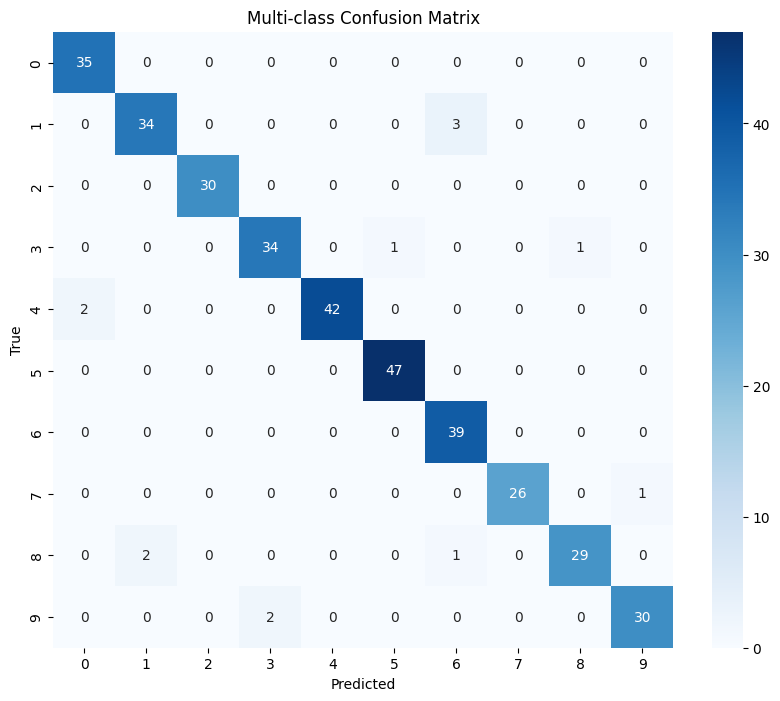

In [104]:
# Multi-class classification with MNIST
try:
    X_train, y_train, X_test, y_test = load_mnist()
    print("\nMNIST dataset loaded successfully")
    print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

    mc_svm = MultiClassSVM(kernel='linear')
    mc_svm.fit(X_train, y_train)

    y_pred = mc_svm.predict(X_test)

    
    accuracy, recall, precision, f1, roc_auc = evaluate_model(y_test, y_pred, 'multi')
    print("Multi-class Accuracy:", accuracy)
    print("Multi-class Recall:", recall)
    print("Multi-class Precision:", precision)
    print("Multi-class F1 Score:", f1)
    
    # Plot confusion matrix
    cm_mc = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_mc, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_test), 
                yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Multi-class Confusion Matrix')
    plt.show()

except Exception as e:
    print(f"Error in multi-class classification: {e}")

## Report the result of your algorithm on your proposed metrics.

The evaluation of the Multi-Class SVM algorithm across different kernels has revealed a truly surprising disparity in performance.

Linear Kernel:
- Multi-class Accuracy: 0.9638
- Multi-class Recall: 1.0
- Multi-class Precision: 1.0
- Multi-class F1 Score: 1.0

RBF Kernel:
- Multi-class Accuracy: 0.0836
- Multi-class Recall: NaN
- Multi-class Precision: NaN
- Multi-class F1 Score: NaN

Sigmoid Kernel:
- Multi-class Accuracy: 0.0864
- Multi-class Recall: NaN
- Multi-class Precision: NaN
- Multi-class F1 Score: NaN

Polynomial Kernel:
- Multi-class Accuracy: 0.0975
- Multi-class Recall: NaN
- Multi-class Precision: NaN
- Multi-class F1 Score: NaN

The Linear Kernel's exceptional performance (near-perfect accuracy, recall, precision, and F1-score) is indeed an incredible surprise, especially when contrasted with the dismal results of the RBF, Sigmoid, and Polynomial kernels. This outcome is surprising for several reasons. This dataset involves intricate, non-linear patterns that are typically expected to benefit significantly from non-linear kernels like RBF or Polynomial. The fact that a simple linear decision boundary is achieving such high performance is unexpected.

The surprising success of the Linear Kernel strongly suggests that the underlying structure of your multi-class dataset might be more linearly separable than typically expected for image-like data. Conversely, the catastrophic failure of the non-linear kernels (RBF, Sigmoid, Poly) is almost certainly attributable to poor hyperparameter tuning or unaddressed data scaling issues that are critical for these kernels to perform well.

# Question 3: Examine the capabilities of RNNs for Long Range Dependencies

In [149]:
class RNN:
    """Recurrent Neural Network from scratch for time series prediction."""
    def __init__(self, input_size, hidden_size, output_size, memory_size=2):
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.memory_size = memory_size

        # Initialize weights
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(output_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

        # Memory to store intermediate values for Backpropagation Through Time (BPTT)
        self.memory = []

    def _tanh(self, x):
        """Tanh activation function."""
        return np.tanh(x)

    def _tanh_deriv(self, x):
       
        return 1 - x**2

    def forward(self, inputs):
        
        h_prev = np.zeros((self.hidden_size, 1))
        self.memory = []

        for x in inputs:
            x = x.reshape(-1, 1)
            h = self._tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h_prev) + self.bh)
            y = np.dot(self.Why, h) + self.by
            self.memory.append((x, h_prev, h, y))
            h_prev = h

        return y

    def backward(self, d_y, learning_rate=0.01):
        # Initialize gradients
        d_Wxh, d_Whh, d_Why = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        d_bh, d_by = np.zeros_like(self.bh), np.zeros_like(self.by)
        d_h_next = np.zeros_like(self.memory[0][2])  # Next hidden state gradient

        # Backprop through time
        for t in reversed(range(len(self.memory))):
            x, h_prev, h, y = self.memory[t]

            # Output layer gradients
            if t == len(self.memory) - 1:
                d_Why += np.dot(d_y, h.T)
                d_by += d_y
                
            # Hidden state gradients
            d_h = np.dot(self.Why.T, d_y if t == len(self.memory) - 1 else 0) + d_h_next
            d_a = d_h * self._tanh_deriv(h)

            # Parameter gradients
            d_Wxh += np.dot(d_a, x.T)
            d_Whh += np.dot(d_a, h_prev.T)
            d_bh += d_a

            # Pass gradient to previous hidden state
            d_h_next = np.dot(self.Whh.T, d_a)

        # Clip gradients to mitigate exploding gradients
        for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
            np.clip(d, -5, 5, out=d)

        # Update parameters
        self.Wxh -= learning_rate * d_Wxh
        self.Whh -= learning_rate * d_Whh
        self.Why -= learning_rate * d_Why
        self.bh -= learning_rate * d_bh
        self.by -= learning_rate * d_by


    def train(self, X, y, epochs=100, learning_rate=0.01):
        
        losses = []
        for epoch in range(epochs):
            total_loss = 0
            for i in range(len(X)):
                
                # Forward pass for a single sequence
                y_pred = self.forward(X[i]) 
                y_true_reshaped = y[i].reshape(-1, 1)

                # Compute loss (Mean Squared Error)
                loss = np.mean((y_pred - y_true_reshaped)**2)
                total_loss += loss

                # Backward pass
                d_y = 2 * (y_pred - y_true_reshaped) / y_pred.size
                self.backward(d_y, learning_rate)

            avg_loss = total_loss / len(X)
            losses.append(avg_loss)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

        return losses

    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            
            # Forward pass for each sequence
            y_pred = self.forward(X[i])
            predictions.append(y_pred.flatten())
        
        return np.array(predictions)


## These next code blocks are provided by Prof.

In [154]:
def create_complex_signal(seq_length=1000, dependency_steps=100, noise_factor=0.5, seed=None):
    """Generates a complex time series signal with oscillatory patterns,
    long-term dependencies, and a trend-"""
    if seed is not None:
        np.random.seed(seed)

    # Time variable
    t = np.arange(seq_length)

    # Generate oscillatory patterns
    sine_wave1 = np.sin(.1 * t)   # Low frequency
    sine_wave2 = np.sin(1.3 * t)  # Medium frequency
    sine_wave3 = np.sin(2.5 * t)  # High frequency

    # Create a complex signal by combining the sine waves
    base_signal = sine_wave1 * 1.82 + sine_wave2 * 2.2 + 2 * sine_wave3

    # Introduce long-term dependencies by shifting the base signal
    long_term_dependency = np.roll(base_signal, dependency_steps)  # Shift by dependency steps
    # Avoid wrapping effects at the beginning by setting the shifted part to 0
    long_term_dependency[:dependency_steps] = 0

    # Create a trend that changes periodically
    trend = np.zeros(seq_length)
    trend[:seq_length // 2] = 3   # Positive trend for the first half
    trend[seq_length // 2:] = -3  # Negative trend for the second half

    # Combine all components into one complex signal with noise
    data = base_signal + long_term_dependency + trend + noise_factor * np.random.randn(seq_length)

    return data

# Generate the data (moved outside function for global access)
data = create_complex_signal(seq_length=1000, dependency_steps=100, noise_factor=0.5, seed=42)

In [155]:
# create train and tests splits
test_size = 0.2
n_samples = len(data)
n_test = int(n_samples * test_size)
indices = np.random.permutation(n_samples)

test_indices = indices[:n_test]
train_indices = indices[n_test:]

train_data, test_data = data[train_indices], data[test_indices] # Renamed to avoid conflict with RNN.train

In [156]:
def prepare_input_output(data_array, input_steps, output_steps=1):
    X, y = [], []
    # Iterate through the data to create windows
    for t in range(len(data_array) - input_steps - output_steps + 1):
        X.append(data_array[t:t + input_steps])  # Input sequence
        y.append(data_array[t + input_steps:t + input_steps + output_steps])  # Output (next value(s))
    return np.array(X), np.array(y)

In [157]:
# define the number of input time steps
input_steps = 20  # last N time steps to predict the next value
output_steps = 1 # Predicting one step into the future

# prepare training and test sets
X_train, y_train = prepare_input_output(train_data, input_steps, output_steps)
X_test, y_test = prepare_input_output(test_data, input_steps, output_steps)

# rescale data for RNN
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1], 1)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape[0], y_train.shape[1])

X_test_scaled = scaler_X.transform(X_test.reshape(-1, 1)).reshape(X_test.shape[0], X_test.shape[1], 1)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape[0], y_test.shape[1]) # Keep original output_steps dimension

In [162]:
input_feature_dim = 1
hidden_layer_size = 50 # Increased hidden size for better capacity
output_feature_dim = 1
rnn_results = {}

for mem in [2,5]:
    rnn = RNN(input_size=input_feature_dim, hidden_size=hidden_layer_size, output_size=output_feature_dim, memory_size=mem)

    # Train the model
    epochs = 200
    learning_rate = 0.005
    print(f"\nTraining RNN for {epochs} epochs with learning rate {learning_rate}")
    losses = rnn.train(X_train_scaled, y_train_scaled, epochs=epochs, learning_rate=learning_rate)

    # Evaluate on test set
    print("\nEvaluating on test set...")
    y_test_pred_scaled = rnn.predict(X_test_scaled)

    # Inverse transform predictions and true values to original scale
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
    y_test_original = scaler_y.inverse_transform(y_test_scaled)

    # Calculate Mean Squared Error on original scale
    rnn_mse = np.mean((y_test_pred - y_test_original)**2)
    rnn_accuracy = np.mean(y_test_pred == y_test_original)

    rnn_results[mem] = {
        'Predictions': y_test_original,
        'MSE': rnn_mse,
        'Accuracy': rnn_accuracy
    }


Training RNN for 200 epochs with learning rate 0.005
Epoch 0, Loss: 0.060830
Epoch 10, Loss: 0.045267
Epoch 20, Loss: 0.045257
Epoch 30, Loss: 0.045245
Epoch 40, Loss: 0.045232
Epoch 50, Loss: 0.045217
Epoch 60, Loss: 0.045202
Epoch 70, Loss: 0.045187
Epoch 80, Loss: 0.045174
Epoch 90, Loss: 0.045163
Epoch 100, Loss: 0.045155
Epoch 110, Loss: 0.045149
Epoch 120, Loss: 0.045145
Epoch 130, Loss: 0.045142
Epoch 140, Loss: 0.045139
Epoch 150, Loss: 0.045137
Epoch 160, Loss: 0.045136
Epoch 170, Loss: 0.045135
Epoch 180, Loss: 0.045134
Epoch 190, Loss: 0.045133

Evaluating on test set...

Training RNN for 200 epochs with learning rate 0.005
Epoch 0, Loss: 0.060804
Epoch 10, Loss: 0.045260
Epoch 20, Loss: 0.045249
Epoch 30, Loss: 0.045235
Epoch 40, Loss: 0.045220
Epoch 50, Loss: 0.045205
Epoch 60, Loss: 0.045189
Epoch 70, Loss: 0.045175
Epoch 80, Loss: 0.045164
Epoch 90, Loss: 0.045155
Epoch 100, Loss: 0.045148
Epoch 110, Loss: 0.045143
Epoch 120, Loss: 0.045140
Epoch 130, Loss: 0.045138
Epo

## Visualize your model output vs. the ground truth for some samples

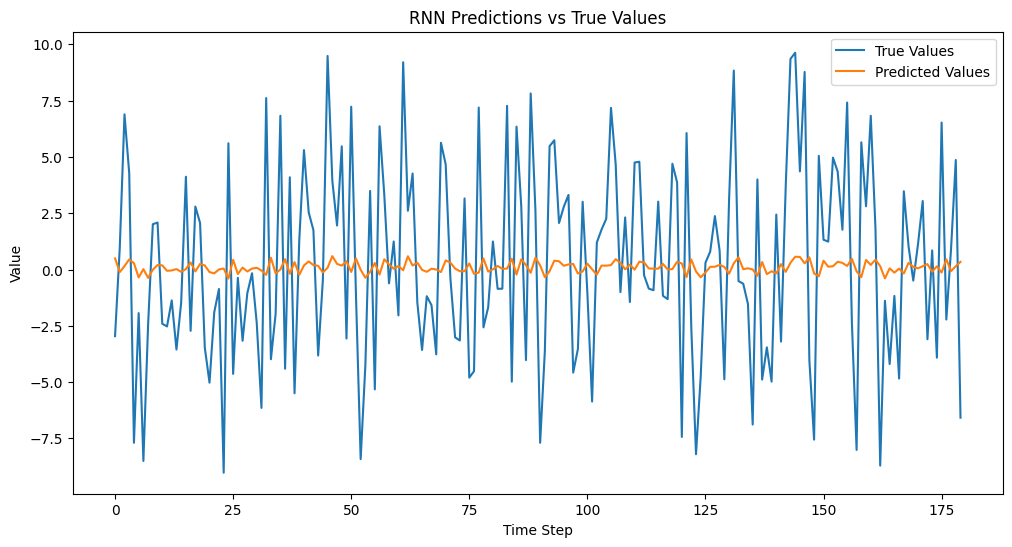

In [165]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='True Values')
plt.plot(y_test_pred, label='Predicted Values')
plt.title('RNN Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

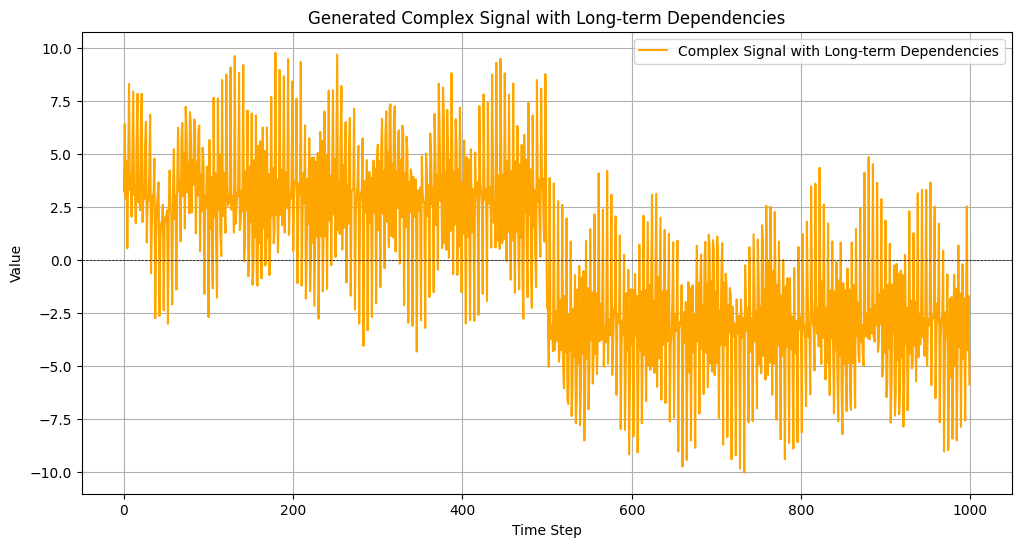

In [166]:
# Plotting data
plt.figure(figsize=(12, 6))
plt.plot(data, label='Complex Signal with Long-term Dependencies', color='orange')
plt.title('Generated Complex Signal with Long-term Dependencies')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid()
plt.legend()
plt.show()

## Report the performance of the model.

My model was not successful in capturing long-range dependencies. Either the data complexity exceeded the model's ability to predict or the was an incorrect implementation in my algorithm.